In [3]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import numpy as np
import csv
from scipy import stats
import trompy as tp

import pandas as pd
from statsmodels.stats.anova import AnovaRM

%matplotlib inline

In [4]:
# fig settings
scattersize=50
colors = ['darkturquoise','dodgerblue', 'darkblue']

In [5]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
statsfolder = "C:\\Github\\Distraction-Paper\\stats\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

In [6]:
# thph2.8 removed from analysis because no data on habituation day

modDict.pop('thph2.8')
disDict.pop('thph2.8')
;

''

In [7]:
# adds parameters used for figures - no. of distractors, distracted, not distracted and calculates probability of distraction

for day in [modDict, disDict, habDict]:
    rats = day.keys()
    for rat in rats:
        d = day[rat]
        # check that numbers add up
        d ['#ds'] =len(d['distractors'])
        d ['#distracted'] =len(d['distracted'])
        d ['#not-dis'] =len(d['notdistracted'])   
        if d['#not-dis'] + d['#distracted'] == d['#ds']:
            d['prob-distracted'] = d['#distracted'] / d['#ds']
        else:
            print("Something wrong in the number of distracted and non-distracted trials")


In [8]:
def find_tercile_prob(d, verbose=False):
    """ Finds probability distracted for each tercile from distraction data dictionary
    
    Args
    d - dictionary with distraction data
    
    Returns
    tercile_prob_distracted - list of 3 values"""
    
    tercile_length = int(np.round((d["#ds"] / 3)))
    tercile_length_array = [tercile_length, d["#ds"] - tercile_length*2, tercile_length]

    dba = d["d_bool_array"]
    t1 = sum(dba[:tercile_length_array[0]])
    t2 = sum(dba[tercile_length_array[0]:tercile_length_array[1]+tercile_length_array[0]])
    t3 = sum(dba[tercile_length_array[1]+tercile_length_array[0]:])

    tercile_prob_distracted = []
    for t_sum, t_len in zip([t1, t2, t3], tercile_length_array):
        tercile_prob_distracted.append(t_sum / t_len)


    if sum([t1, t2, t3]) != len(d["distracted"]):
        print("Check tercile calculation")
        
    if verbose:
        print(d["rat"], sum([t1, t2, t3]), len(d["distracted"]), len(d["notdistracted"]), print(sum(dba)))
        print("Tercile length array", tercile_length_array)
        print("Number of distractors", d["#ds"])
        print(dba)
        print("Tercile probability of distraction", tercile_prob_distracted)
        print("Number of Trues in each tercile", t1, t2, t3)
        print("\n")
        
    return tercile_prob_distracted

rats = modDict.keys()

all_tercile_probs = []
for rat in rats:
    t_probs = []
    t_probs.append(find_tercile_prob(modDict[rat]))
    t_probs.append(find_tercile_prob(disDict[rat]))
    t_probs.append(find_tercile_prob(habDict[rat]))
    
    all_tercile_probs.append(tp.flatten_list(t_probs))

all_tercile_probs_array = np.array(all_tercile_probs)

In [9]:
def find_tercile_aucs(d, epoch=[60, 90], signal="filt_z"):
    """ Finds probability distracted for each tercile from distraction data dictionary
    
    Args
    d - dictionary with distraction data from single rat
    
    Returns
    tercile_prob_distracted - list of 3 values"""
    
    tercile_length = int(np.round((d["#ds"] / 3)))
    tercile_length_array = [tercile_length, d["#ds"] - tercile_length*2, tercile_length]

    snips = d["snips_distractors"][signal]
    t1 = [np.mean(snip[epoch[0]:epoch[1]]) for snip in snips[:tercile_length_array[0]]]
    t2 = [np.mean(snip[epoch[0]:epoch[1]]) for snip in snips[tercile_length_array[0]:tercile_length_array[1]+tercile_length_array[0]]]
    t3 = [np.mean(snip[epoch[0]:epoch[1]]) for snip in snips[tercile_length_array[1]+tercile_length_array[0]:]]
    
    
    tercile_aucs = []
    for t in [t1, t2, t3]:
        tercile_aucs.append(np.mean(t))
    
    return tercile_aucs

rats = modDict.keys()

all_tercile_aucs = []
for rat in rats:
    t_aucs= []
    t_aucs.append(find_tercile_aucs(modDict[rat]))
    t_aucs.append(find_tercile_aucs(disDict[rat]))
    t_aucs.append(find_tercile_aucs(habDict[rat]))
    
    all_tercile_aucs.append(tp.flatten_list(t_aucs))


In [10]:
all_tercile_aucs_array = np.array(all_tercile_aucs)

dis_probs = all_tercile_probs_array[:,3:6]
dis_aucs = all_tercile_aucs_array[:,3:6]

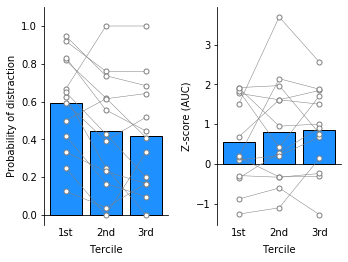

In [11]:
f, [ax1, ax2] = plt.subplots(ncols=2, figsize=(5.5,4))
f.subplots_adjust(left=0.15, wspace=0.4)


_, barx, _, _ = tp.barscatter(dis_probs.T, paired=True,
              barfacecolor=[colors[1]], barfacecoloroption='same',
              scattersize=scattersize,
              ax=ax1)

tp.barscatter(dis_aucs.T, paired=True,
              barfacecolor=[colors[1]], barfacecoloroption='same',
              scattersize=scattersize,
              ax=ax2)

ax1.set_ylabel("Probability of distraction")
ax2.set_ylabel("Z-score (AUC)")

ax1.set_ylim([-0.05, 1.1])

barlabels=['1st', '2nd', '3rd']

for axis in [ax1, ax2]:
    trans = transforms.blended_transform_factory(
                axis.transData, axis.transAxes)
    for x, label in zip(barx, barlabels):
        axis.text(x, -0.05, label, ha="center", transform=trans)
    axis.text(barx[1], -0.13, "Tercile", ha="center", transform=trans)
        
f.savefig(figfolder + "within_session_hab.pdf")

In [12]:


rats = disDict.keys()
data = np.array(dis_probs, dtype="float")


df = pd.DataFrame(data, columns=["1", "2", "3"], index=rats)
df.insert(0, "ratid", rats)
df = df.melt(id_vars = "ratid")

aovrm = AnovaRM(df, "value", "ratid", within=["variable"])
res = aovrm.fit()

print(res)
t, p = stats.ttest_rel(dis_probs.T[0], dis_probs.T[1])
print('1 v 2', t, p, "Sidak:", tp.sidakcorr(p))

t, p = stats.ttest_rel(dis_probs.T[0], dis_probs.T[2])
print('1 v 3', t, p, "Sidak:", tp.sidakcorr(p))

t, p = stats.ttest_rel(dis_probs.T[1], dis_probs.T[2])
print('2 v 3', t, p, "Sidak:", tp.sidakcorr(p))

data = np.array(dis_aucs, dtype="float")


df = pd.DataFrame(data, columns=["1", "2", "3"], index=rats)
df.insert(0, "ratid", rats)
df = df.melt(id_vars = "ratid")

aovrm = AnovaRM(df, "value", "ratid", within=["variable"])
res = aovrm.fit()

print(res)

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
variable  5.0127 2.0000 24.0000 0.0152

1 v 2 2.8236282257268974 0.015356220065884196 Sidak: 0.04536484091743631
1 v 3 2.29752885513493 0.04037776743507989 Sidak: 0.11630804045870269
2 v 3 0.637804302216334 0.5355821448177593 Sidak: 0.8998325252317831
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
variable  0.7818 2.0000 24.0000 0.4689

